In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [143]:
df= pd.read_csv(r"C:\Study Hub\notebooks\TrafficPrediction\merged_rieds_weather_100000.csv", index_col=0)
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,humidity,wind
0,1.49,Uber,2018-12-15 15:50:08.710,North End,Beacon Hill,26.0,1.0,Black SUV,15,2018-12-15,47.73,0.96,1022.45,0.860,4.06
1,1.28,Lyft,2018-12-14 23:10:15.587,North End,Financial District,7.0,1.0,Lyft,23,2018-12-14,42.41,0.88,1027.60,0.750,4.55
2,1.30,Uber,2018-12-02 03:28:01.882,Theatre District,South Station,27.5,1.0,Black SUV,3,2018-12-02,36.84,0.38,1022.89,0.810,0.30
3,2.28,Lyft,2018-11-30 01:57:59.147,Boston University,Beacon Hill,16.5,1.0,Lyft XL,1,2018-11-30,37.47,0.04,1012.02,0.660,7.94
4,1.27,Lyft,2018-11-27 15:18:22.350,Haymarket Square,Beacon Hill,11.0,1.0,Lyft XL,15,2018-11-27,40.98,1.00,989.33,0.875,10.77


# Feature Engineering

In [144]:
# calculate price of km
df['price_of_km']= df['price']/ df['distance'].clip(lower=1e-6)
# Extract temporal features from ride timestamps to capture daily and monthly patterns.
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day
df['month']= df['date'].dt.month
# Encode hour of day using sine and cosine transformations to preserve its cyclical nature
df['hour'].astype(float)
df['hour_sin']= np.sin(2* np.pi * df['hour'] / 24)
df['hour_cos']= np.cos(2* np.pi * df['hour'] / 24)

df["route"] = df["source"].astype(str) + "_" + df["destination"].astype(str)
route_freq = df["route"].value_counts(normalize=True)
df["route_freq"] = df["route"].map(route_freq)

In [145]:
df['month'].value_counts()

month
12    58700
11    41300
Name: count, dtype: int64

In [146]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,...,pressure,humidity,wind,price_of_km,day,month,hour_sin,hour_cos,route,route_freq
0,1.49,Uber,2018-12-15 15:50:08.710,North End,Beacon Hill,26.0,1.0,Black SUV,15,2018-12-15,...,1022.45,0.860,4.06,17.449664,15,12,-0.707107,-0.707107,Beacon Hill_North End,0.01553
1,1.28,Lyft,2018-12-14 23:10:15.587,North End,Financial District,7.0,1.0,Lyft,23,2018-12-14,...,1027.60,0.750,4.55,5.468750,14,12,-0.258819,0.965926,Financial District_North End,0.01301
2,1.30,Uber,2018-12-02 03:28:01.882,Theatre District,South Station,27.5,1.0,Black SUV,3,2018-12-02,...,1022.89,0.810,0.30,21.153846,2,12,0.707107,0.707107,South Station_Theatre District,0.01389
3,2.28,Lyft,2018-11-30 01:57:59.147,Boston University,Beacon Hill,16.5,1.0,Lyft XL,1,2018-11-30,...,1012.02,0.660,7.94,7.236842,30,11,0.258819,0.965926,Beacon Hill_Boston University,0.01416
4,1.27,Lyft,2018-11-27 15:18:22.350,Haymarket Square,Beacon Hill,11.0,1.0,Lyft XL,15,2018-11-27,...,989.33,0.875,10.77,8.661417,27,11,-0.707107,-0.707107,Beacon Hill_Haymarket Square,0.01403


In [147]:
numeric_cols=["distance","hour_sin",'hour_cos','day','month', 'route_freq']
categorical_cols= ['cab_type']

In [154]:
preprocessor= ColumnTransformer(transformers= [
         ("num", StandardScaler(), numeric_cols),
         ("cat", OneHotEncoder(drop= 'first', handle_unknown="ignore", sparse_output=False), categorical_cols)
         ],
         remainder= 'drop'
         )

# Kmeans

In [155]:
kmeans_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("pca", PCA(n_components=0.90, random_state=42)),
    ("kmeans", KMeans(
        n_clusters=10,
        init="k-means++",
        n_init="auto",
        random_state=42
    ))
])


In [157]:
df['mobility_cluster']= kmeans_pipe.fit_predict(df)

In [162]:
cluster_counts = df["mobility_cluster"].value_counts().sort_index()
cluster_counts


mobility_cluster
0     5921
1    14199
2     8865
3    13795
4    10198
5     8647
6     4656
7    12213
8     7525
9    13981
Name: count, dtype: int64

In [167]:
profile = (
    df.groupby("mobility_cluster")
    .agg(
        rides=("mobility_cluster", "count"),
        avg_price=("price", "mean"),
        median_price=("price", "median"),
        avg_distance=("distance", "mean"),
        surge_rate=("surge_multiplier", lambda x: (x > 1).mean()),
        peak_hour=("hour", lambda x: x.mode()[0])
    )
    .round(2)
)

profile

,rides,avg_price,median_price,avg_distance,surge_rate,peak_hour
mobility_cluster,,,,,,
0,5921,15.47,13.5,1.58,0.11,0
1,14199,19.04,16.5,2.25,0.25,2
2,8865,16.45,13.5,1.71,0.17,18
3,13795,18.82,16.5,2.23,0.24,18
4,10198,20.54,17.0,2.61,0.27,23
5,8647,16.83,14.5,1.77,0.18,10
6,4656,27.40,26.0,4.79,0.22,2
7,12213,14.21,11.5,1.22,0.08,5
8,7525,22.78,19.5,3.15,0.28,13


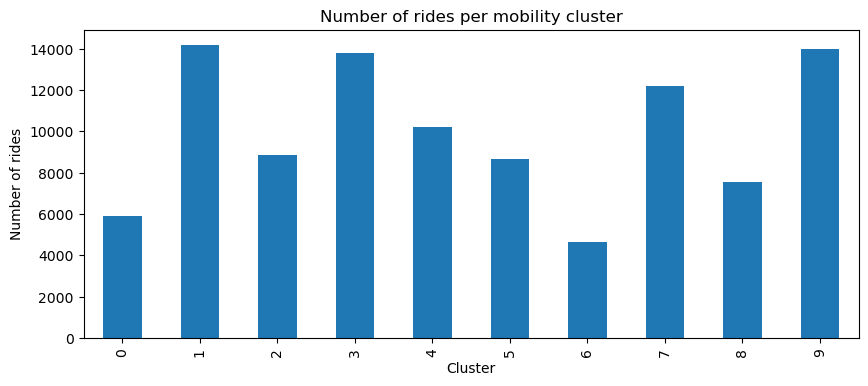

In [168]:
cluster_counts.plot(kind="bar", figsize=(10,4))
plt.title("Number of rides per mobility cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of rides")
plt.show()

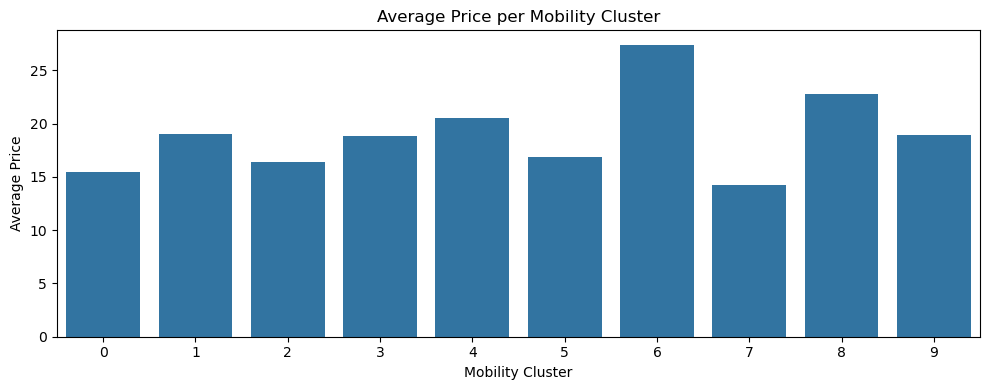

In [172]:
plt.figure(figsize=(10,4))
sns.barplot(
    data=profile.reset_index(),
    x="mobility_cluster",
    y="avg_price"
)

plt.title("Average Price per Mobility Cluster")
plt.xlabel("Mobility Cluster")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()


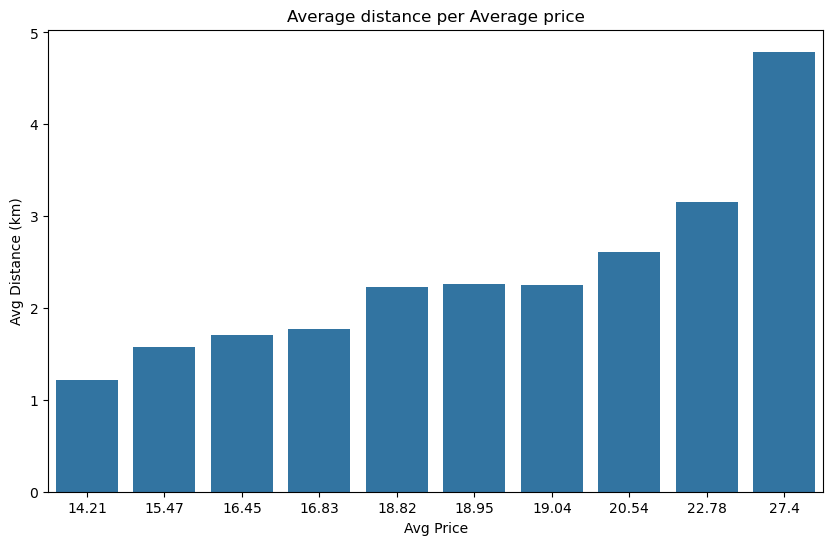

In [178]:
plt.figure(figsize=(10,6))
sns.barplot(
    data= profile.reset_index(),
    x= 'avg_price',
    y= 'avg_distance'
)
plt.title("Average distance per Average price")
plt.xlabel("Avg Price")
plt.ylabel("Avg Distance (km)")
plt.show()

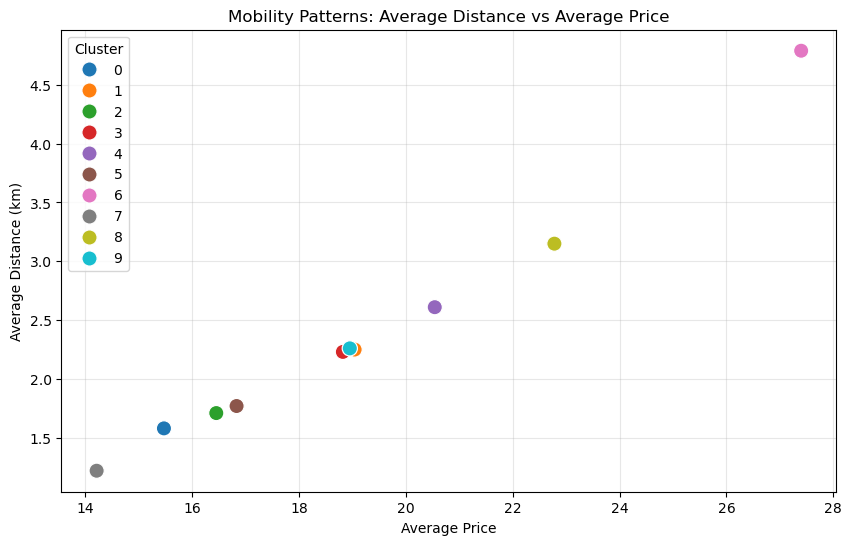

In [179]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=profile.reset_index(),
    x="avg_price",
    y="avg_distance",
    hue="mobility_cluster",
    palette="tab10",
    s=120
)

plt.title("Mobility Patterns: Average Distance vs Average Price")
plt.xlabel("Average Price")
plt.ylabel("Average Distance (km)")
plt.legend(title="Cluster")
plt.grid(True, alpha=0.3)
plt.show()


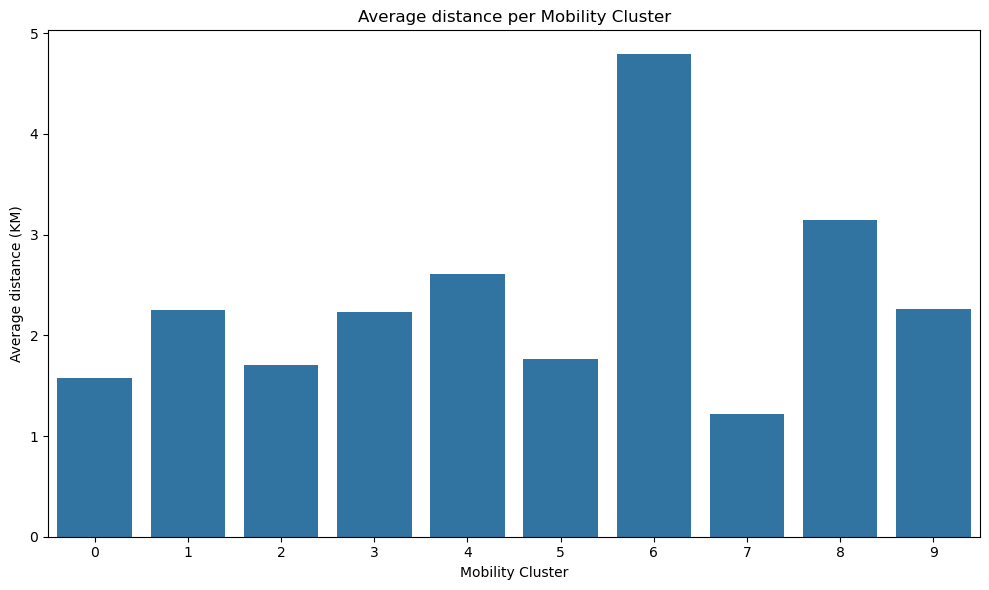

In [182]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=profile.reset_index(),
    x="mobility_cluster",
    y="avg_distance"
)

plt.title("Average distance per Mobility Cluster")
plt.xlabel("Mobility Cluster")
plt.ylabel("Average distance (KM)")
plt.tight_layout()
plt.show()


# DBSCAN for Anomaly Detection

In [205]:
db_features= ["distance","price","price_of_km","surge_multiplier","hour_sin","hour_cos","route_freq"]
scaler= StandardScaler()
X_db= df[db_features].copy()
X_scaled= scaler.fit_transform(X_db)

In [232]:
dbScan= DBSCAN(eps= 1, min_samples= 14)
df['dbscan_label']= dbscan.fit_predict(X_db_scaled)

In [233]:
df['is_anomaly']= df['dbscan_label']== -1
df["is_anomaly"].value_counts(normalize=True)


is_anomaly
False    0.99461
True     0.00539
Name: proportion, dtype: float64

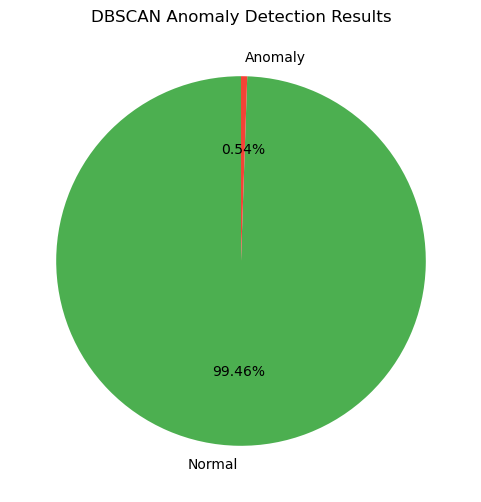

In [234]:
counts = df["is_anomaly"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(
    counts,
    labels=["Normal", "Anomaly"],
    autopct="%.2f%%",
    colors=["#4CAF50", "#F44336"],
    startangle=90
)
plt.title("DBSCAN Anomaly Detection Results")
plt.show()

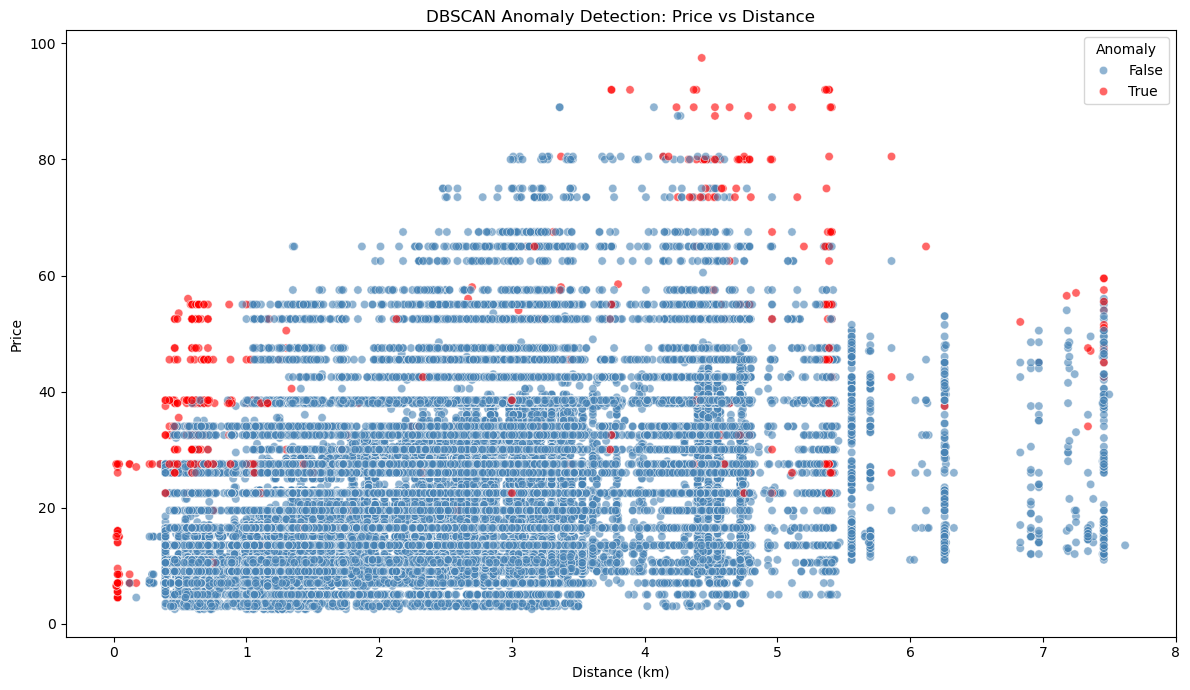

In [235]:
plt.figure(figsize=(12,7))
sns.scatterplot(data= df, x= 'distance', y= 'price', hue= 'is_anomaly', palette={False: "steelblue", True: "red"},alpha=0.6)
plt.title("DBSCAN Anomaly Detection: Price vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Price")
plt.legend(title="Anomaly")
plt.tight_layout()
plt.show()

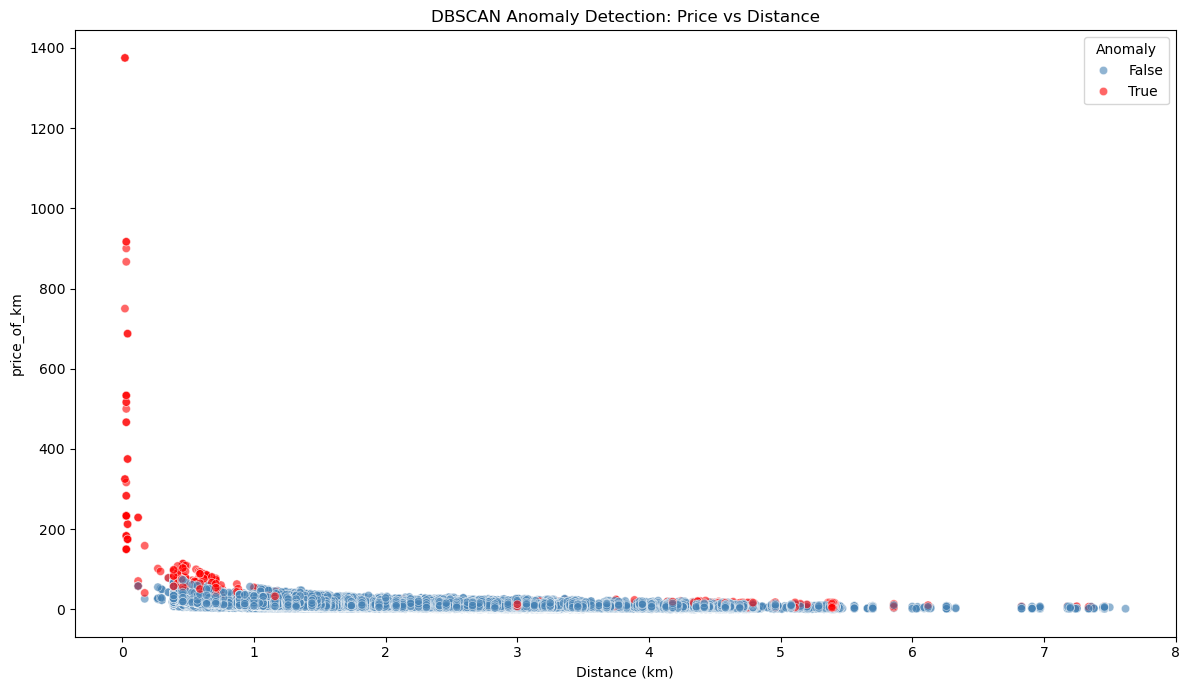

In [236]:
plt.figure(figsize=(12,7))
sns.scatterplot(data= df, x= 'distance', y= 'price_of_km', hue= 'is_anomaly', palette={False: "steelblue", True: "red"},alpha=0.6)
plt.title("DBSCAN Anomaly Detection: Price vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("price_of_km")
plt.legend(title="Anomaly")
plt.tight_layout()
plt.show()